# Weather, heating power, RSWT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Parameters
ALPHA=12
BETA=-0.22
GAMMA = 0.002
INTERMEDIATE_POWER = 1.5
INTERMEDIATE_RSWT=130
DD_POWER = 12
DD_RSWT=180
DD_DELTA_T = 20

NO_POWER_RSWT = -ALPHA/BETA

if ALPHA != DD_POWER:
    raise ValueError("ALPHA and DD_POWER must be equal")

## Required heating power as a function of weather

Weather is both the outside air temperature $T_{OA}$ (in F) and the wind speed $WS$ (in mph). A linear regression using past data gives us the parameters $\alpha$, $\beta$, and $\gamma$ of the approximation for the required heating power $\dot{Q}$ in kW: 
$$
\dot{Q}(T_{OA}, WS) \approx \alpha + \beta \cdot T_{OA} + \gamma \cdot WS \cdot (T_{OA}-65)
$$

It follows that the source water temperature at which the house receives no heating power on a day without wind is simply $-\frac{\alpha}{\beta}$.

In [4]:
def required_heating_power(oat, ws):
    r = ALPHA + BETA*oat + GAMMA*ws*(oat-65)
    return r if r>0 else 0

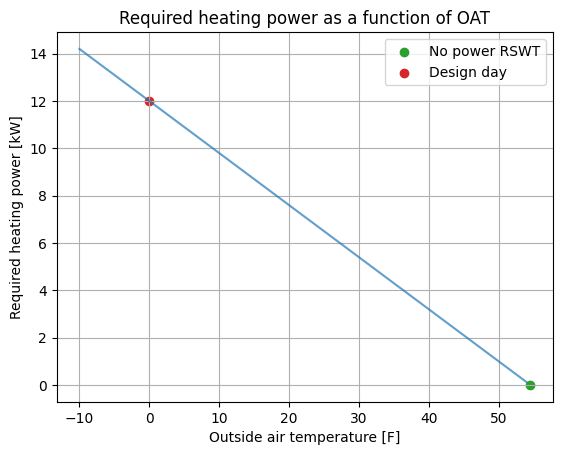

In [5]:
oats = list(range(-10, int(NO_POWER_RSWT)+1))
wss = [0]*len(oats)
plt.plot(oats, [required_heating_power(x,y) for x,y in zip(oats,wss)], alpha=0.7)
plt.scatter(NO_POWER_RSWT, 0, color='tab:green', label='No power RSWT')
plt.scatter(0, DD_POWER, color='tab:red', label='Design day')
plt.title("Required heating power as a function of OAT")
plt.ylabel("Required heating power [kW]")
plt.xlabel("Outside air temperature [F]")
plt.grid()
plt.legend()
plt.show()

## Delivered heating power as a function of SWT 

The delivered heating power is not a linear function of SWT. Indeed, natural convection is more efficient at higher temperatures, as reflected by a varying heat transfer coefficient, $h$, in Newton's law for convective heat transport (where $\dot{Q}$ is the heating power and $RT$ is room temperature):

$$
\dot{Q} = h \cdot A \cdot (SWT-RT) 
$$

Determining $h$ as a function of $(SWT-RT)$ is a small exercise that I took the time to do but is not worth doing for every house. What is showed is that the nonlinearity is indeed significant, and that we should be able to get a better approximation of the relationship between SWT and heating power using a quadratic function.

In [6]:
x0 = NO_POWER_RSWT
xi = INTERMEDIATE_RSWT
xd = DD_RSWT

y0 = 0
yi = INTERMEDIATE_POWER
yd = DD_POWER

c = (xi*xd)/(xi-xd) * ((yd*x0)/(xd*(x0-xd)) - (yi*x0)/(xi*(x0-xi)))
b = (yi*x0)/(xi*(x0-xi)) - (x0+xi)/(x0*xi)*c
a = -b/x0 - c/x0/x0
print(f"a = {a}, b = {b}, c = {c}")

a = 0.0015154531168150862, b = -0.2597904662126768, c = 9.661602933473024


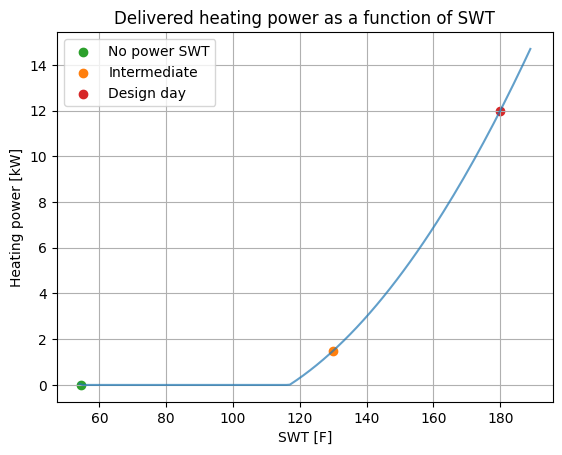

In [7]:
# x_rswt = np.array([NO_POWER_RSWT, INTERMEDIATE_RSWT, DD_RSWT])
# y_hpower = np.array([0, INTERMEDIATE_POWER, DD_POWER])
# A = np.vstack([x_rswt**2, x_rswt, np.ones_like(x_rswt)]).T
# a, b, c = [float(x) for x in np.linalg.solve(A, y_hpower)]
# print(f"a = {a}, b = {b}, c = {c}")

def delivered_heating_power(swt):
    d = a*swt**2 + b*swt + c
    return d if d>0 else 0

rswt = list(range(int(NO_POWER_RSWT), 190))
plt.title("Delivered heating power as a function of SWT")
plt.plot(rswt, [delivered_heating_power(x) for x in rswt], alpha=0.7)
plt.scatter(NO_POWER_RSWT, delivered_heating_power(NO_POWER_RSWT), label="No power SWT", color='tab:green')
plt.scatter(INTERMEDIATE_RSWT, delivered_heating_power(INTERMEDIATE_RSWT), label="Intermediate", color='tab:orange')
plt.scatter(DD_RSWT, delivered_heating_power(DD_RSWT), label="Design day", color='tab:red')
plt.ylabel("Heating power [kW]")
plt.xlabel("SWT [F]")
plt.grid()
plt.legend()
plt.show()

## Required SWT as a function of heating power

The inverse of the previous function gives us the required SWT for a given heating power.

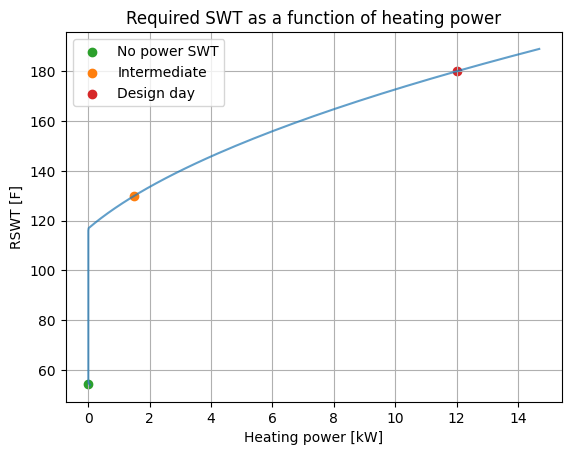

In [8]:
def required_swt(hp):
    c2 = c - hp
    return (-b + (b**2-4*a*c2)**0.5)/(2*a)

rswt = list(range(int(NO_POWER_RSWT),190))
heating_pwr = list(range(0,100))
plt.title(f"Required SWT as a function of heating power")
plt.plot([delivered_heating_power(x) for x in rswt], rswt, alpha=0.7)
plt.scatter(0, NO_POWER_RSWT, label="No power SWT", color='tab:green')
plt.scatter(INTERMEDIATE_POWER, required_swt(INTERMEDIATE_POWER), label="Intermediate", color='tab:orange')
plt.scatter(DD_POWER, required_swt(DD_POWER), label="Design day", color='tab:red')
plt.xlabel("Heating power [kW]")
plt.ylabel("RSWT [F]")
plt.grid()
plt.legend()
plt.show()

## Temperature drop as a function of SWT

$$\dot{Q}(SWT) = \dot{m} \cdot c_p \cdot \Delta T(SWT)$$

The mass flow rate $\dot{m}$ being constant, knowing the $\Delta T$ at the required $\dot{Q}$ on design day gives us:

$$
\Delta T(SWT) = \Delta T(SWT_{dd}) \cdot \frac{\dot{Q}(SWT)}{\dot{Q}(SWT_{dd})}
$$

[]

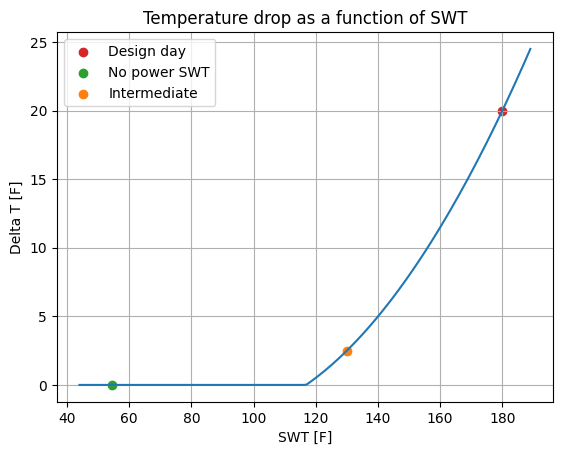

In [9]:
def delta_T(swt):
    d = DD_DELTA_T/DD_POWER * delivered_heating_power(swt)
    d = 0 if swt<NO_POWER_RSWT else d
    return d if d>0 else 0

swt = list(range(int(NO_POWER_RSWT)-10,190))
plt.plot(swt, [delta_T(x) for x in swt])
plt.scatter(DD_RSWT, DD_DELTA_T, label="Design day", color='tab:red')
plt.scatter(NO_POWER_RSWT, 0, label="No power SWT", color='tab:green')
plt.scatter(INTERMEDIATE_RSWT, delta_T(INTERMEDIATE_RSWT), label="Intermediate", color='tab:orange')
plt.title("Temperature drop as a function of SWT")
plt.xlabel("SWT [F]")
plt.ylabel("Delta T [F]")
plt.grid()
plt.legend()
plt.plot()

# Final table

In [10]:
def required_heating_power(oat, ws):
    r = ALPHA + BETA*oat + GAMMA*ws
    return r if r>0 else 0

def delivered_heating_power(swt):
    d = a*swt**2 + b*swt + c
    return d if d>0 else 0

def required_swt(rhp):
    c2 = c-rhp
    return (-b + (b**2-4*a*c2)**0.5)/(2*a)

def delta_T(swt):
    d = DD_DELTA_T/DD_POWER * delivered_heating_power(swt)
    d = 0 if swt<NO_POWER_RSWT else d
    return d if d>0 else 0

oats = sorted(list(range(-10,70,5)), reverse=True)
wss = [0]*len(oats)
df = {
    'oat': oats,
    'ws': wss,
    'kw': [required_heating_power(x,y) for x,y in zip(oats,wss)],
    'rswt': [required_swt(required_heating_power(x,y)) for x,y in zip(oats,wss)],
    'deltaT': [delta_T(required_swt(required_heating_power(x,y))) for x,y in zip(oats,wss)],
}

df = pd.DataFrame(df)
df = round(df,1)
display(df)

,oat,ws,kw,rswt,deltaT
0,65,0,0.0,116.9,0.0
1,60,0,0.0,116.9,0.0
2,55,0,0.0,116.9,0.0
3,50,0,1.0,126.1,1.7
4,45,0,2.1,134.3,3.5
5,40,0,3.2,141.2,5.3
6,35,0,4.3,147.4,7.2
7,30,0,5.4,153.1,9.0
8,25,0,6.5,158.2,10.8
9,20,0,7.6,163.1,12.7


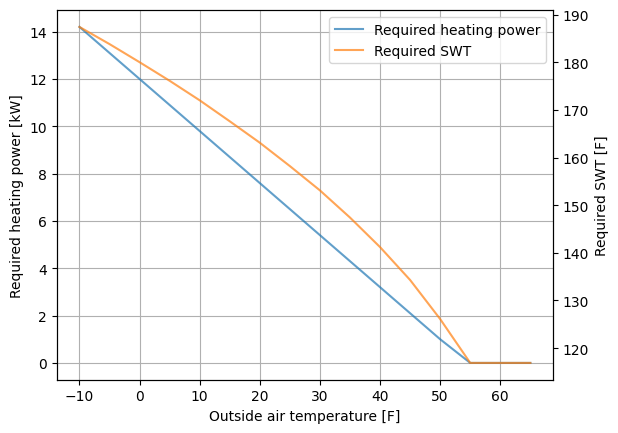

In [15]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(df.oat, df.kw, label='Required heating power', alpha=0.7)
# ax.scatter(NO_POWER_RSWT, 0, color='tab:green', label='No power RSWT')
# ax.scatter(0, DD_POWER, color='tab:red', label='Design day')
ax.set_ylabel('Required heating power [kW]')
ax2.plot(df.oat, df.rswt, color='tab:orange', label='Required SWT', alpha=0.7)
ax2.set_ylabel('Required SWT [F]')
ax.set_xlabel('Outside air temperature [F]')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.grid()
plt.show()

## Dijkstra

In [12]:
# def delivered_heating_power(swt):
#     d = a*swt**2 + b*swt + c
#     return d if d>0 else 0

# def delta_T(swt):
#     d = DD_DELTA_T/DD_POWER * delivered_heating_power(swt)
#     d = 0 if swt<NO_POWER_RSWT else d
#     # d = 30 if d>30 else d
#     return d if d>0 else 0

# def delta_T_inverse(rwt: float) -> float:
#     aa = -DD_DELTA_T/DD_POWER * a
#     bb = 1-DD_DELTA_T/DD_POWER * b
#     cc = -DD_DELTA_T/DD_POWER * c - rwt
#     if bb**2-4*aa*cc < 0 or (-bb + (bb**2-4*aa*cc)**0.5)/(2*aa) - rwt > 30:
#         return 30
#     return (-bb + (bb**2-4*aa*cc)**0.5)/(2*aa) - rwt

# swts = list(range(60,350))
# deltats = [delta_T(x) for x in swts]
# rwts = [x-delta_T(x) for x in swts]
# rwts_inv = list(range(int(min(rwts)),190))
# swts_inv = [x+delta_T_inverse(x) for x in rwts_inv]

# fig, ax = plt.subplots(1,1)
# ax.plot(swts, deltats, color='tab:red', label='Delta T')
# ax2 = ax.twinx()
# ax2.plot(swts, rwts, color='tab:blue', label='RWT')
# ax2.plot(swts_inv, rwts_inv, color='tab:orange', label='RWT inverse')
# ax.set_xlabel('SWT')
# ax.set_ylabel('Delta T')
# ax2.set_ylabel('RWT')
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.title('Maximum Delta T = 30 F')
# plt.show()

In [13]:
# MAX_TOP_TEMP = 185
# MIN_TOP_TEMP = 70

# def to_celcius(t):
#     return round((t-32)*5/9)

# def get_available_top_temps(initial_top_temp):
#     available_temps = [initial_top_temp]
#     x = initial_top_temp
#     while round(x + delta_T_inverse(x),2) <= MAX_TOP_TEMP:
#         x = round(x + delta_T_inverse(x),2)
#         available_temps.append(int(x))
#     while x+10 <= MAX_TOP_TEMP:
#         x += 10
#         available_temps.append(int(x))
#     x = initial_top_temp
#     while delta_T(x) >= 3:
#         x = round(x - delta_T(x))
#         available_temps.append(int(x))
#     while x >= MIN_TOP_TEMP:
#         x += -10
#         available_temps.append(int(x))
#     available_temps = sorted(available_temps)
#     if max(available_temps) < 176:
#         available_temps = available_temps + [185]    
#     print(available_temps)

# get_available_top_temps(100)
